## Application of batch-mode regression to cross-validation

botorch provides a helper function `gen_loo_cv_folds` to easily perform leave-one-out (LOO) cross-validation (CV) by taking advantage of batch-mode regression and evaluation in GPyTorch. This tutorial illustrates the process on a noisy sinusoidal function, similar to the example from the batch-mode GP regression [tutorial](https://github.com/cornellius-gp/gpytorch/blob/master/examples/01_Simple_GP_Regression/Simple_Batch_Mode_GP_Regression.ipynb) from GPyTorch:

$$y = \sin(2\pi x) + \epsilon, ~\epsilon \sim \mathcal N(0, 0.2).$$

Note: this tutorial aims to introduce batch-mode regression and evaluation in GPyTorch with CV as an example application. For alternative, more user-friendly functions to perform CV, see [**TODO**: link to Ax]. However, for larger CV tasks, it may be useful to exploit GPyTorch batch-mode, as shown in this tutorial.

In [1]:
import torch
import math

device = torch.device("cpu")
dtype = torch.float
torch.manual_seed(3);

#### Initialize the CV dataset

For our training data, we take 20 regularly spaced points on the interval $[0, 1]$ and generate noisy evaluations with standard deviation 0.2.

In [2]:
sigma = math.sqrt(0.2)
train_x = torch.linspace(0, 1, 20, dtype=dtype, device=device).view(-1, 1)
train_y_noiseless = torch.sin(train_x * (2 * math.pi)).view(-1)
train_y = train_y_noiseless + sigma * torch.randn_like(train_y_noiseless)

The botorch function `gen_loo_cv_folds` takes our dataset `train_x` and `train_y` as input and returns the LOO CV folds in a `CVFolds` object.

In [3]:
from botorch.cross_validation import gen_loo_cv_folds

cv_folds = gen_loo_cv_folds(train_x=train_x, train_y=train_y)

The `cv_folds` object contains the data, stored as tensors of appropriate batch shape, necessary to perform 20 CVs of 19 training points and 1 test point. For example, we can check that the shapes of the training data are `b x n x d = 20 x 19 x 1` and `b x n = 20 x 19`.

In [4]:
cv_folds.train_x.shape, cv_folds.train_y.shape

(torch.Size([20, 19, 1]), torch.Size([20, 19]))

In [5]:
cv_folds.test_x.shape, cv_folds.test_y.shape

(torch.Size([20, 1, 1]), torch.Size([20, 1]))

Note that in a situation where the dataset is large, one may not want to perform LOO; in that case, a similar process can be used to perform $k$-fold CV.

#### Instantiate a batch-mode GP

We can now define and fit a batch-mode GP, meaning that the `b = 20` sets of training data can be fit as `b = 20` separate GP models in parallel through GPyTorch. We use a basic `SingleTaskGP` with inferred noise level.

In [6]:
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

# instantiate and fit model
model = SingleTaskGP(train_X=cv_folds.train_x, train_Y=cv_folds.train_y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
mll = fit_gpytorch_model(mll)

#### Compute the cross-validation error and generate plots
To compute the cross-validation error, we first evaluate the test points by computing the posterior in batch mode. Next, we compute the squared errors for each test point from the prediction and take an average across all cross-validation folds.

Cross-validation error:  0.37


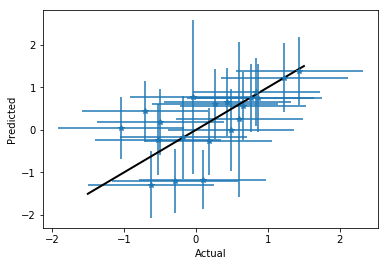

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

with torch.no_grad():
    # evaluate on the test points in batch mode
    posterior = model.posterior(cv_folds.test_x)
    mean = posterior.mean
    cv_error = ((cv_folds.test_y.squeeze() - mean.squeeze()) ** 2).mean()
    print(f"Cross-validation error: {cv_error : 4.2}")
    
    # get lower and upper confidence bounds
    lower, upper = posterior.mvn.confidence_region()
    
    # scatterplot of predicted versus test
    _, axes = plt.subplots(1, 1, figsize=(6, 4))
    plt.plot([-1.5, 1.5], [-1.5, 1.5], 'k', label="true objective", linewidth=2)
    
    axes.set_xlabel("Actual")
    axes.set_ylabel("Predicted")
    
    axes.errorbar(
        x=cv_folds.test_y.numpy(), 
        y=mean.numpy(), 
        xerr=1.96*sigma,
        yerr=((upper-lower)/2).numpy(),
        fmt='*'
    )    

Finally, we can visualize the fitted models. To do this, we again take advantage of batch-mode evaluation to obtain predictions, including lower and upper confidence regions, from each of the 20 models.

In [8]:
with torch.no_grad():
    # evaluate the models at a series of points for plotting 
    plot_x = torch.linspace(0, 1, 101).view(1, -1, 1).repeat(cv_folds.train_x.shape[0], 1, 1)
    posterior = model.posterior(plot_x)
    mean = posterior.mean
    
    # get lower and upper confidence bounds
    lower, upper = posterior.mvn.confidence_region()
    plot_x.squeeze_()

The code snippet below plots the result for the 12th CV fold (by setting `num = 12`), but note that we have computed the results for all folds above (other plots can be obtained by iterating `num` from 1 to 20).

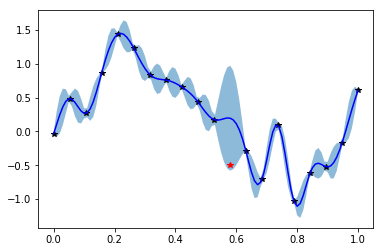

In [9]:
_, axes = plt.subplots(1, 1, figsize=(6, 4))

# plot the 12th CV fold
num = 12 

# plot the training data in black
axes.plot(
    cv_folds.train_x[num - 1].detach().numpy(), 
    cv_folds.train_y[num - 1].detach().numpy(), 
    'k*'
)

# plot the test data in red
axes.plot(
    cv_folds.test_x[num - 1].detach().numpy(), 
    cv_folds.test_y[num - 1].detach().numpy(), 
    'r*'
)

# plot posterior means as blue line
axes.plot(plot_x[num - 1].numpy(), mean[num-1].numpy(), 'b')

# shade between the lower and upper confidence bounds
axes.fill_between(
    plot_x[num - 1].numpy(), 
    lower[num - 1].numpy(), 
    upper[num - 1].numpy(), 
    alpha=0.5
)

Here we can observe that the `SingleTaskGP` we used here infers a really small noise level (and hence overfits the data). If we know that our observations are noisy, a better choice would be a `FixedNoiseGP`, or even a `HeteroskedasticSingleTaskGP`.